In [1]:
# ---- Nested function ---- #
import os
import pandas as pd
import wfdb
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from pprint import pprint
from collections import Counter
import math
from copy import deepcopy
import random

# # ---- BWR ---- #
# import bwr
# import emd
# import pywt
# ---- Scipy ---- #
from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.fftpack import fft
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


# ---- PyTorch ---- #
import torch
from torch import nn
from torch import optim
from torch import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor
from torch.nn.functional import softmax
from torch.nn.parallel import DistributedDataParallel
from pytorchtools import EarlyStopping
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import tensorboard
from tensorboardX import SummaryWriter

# ---- Scikit Learn ---- #
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import KFold


# ---- Matplotlib ---- #
import matplotlib.pyplot as plt

# ---- Summary ---- #
import pytorch_model_summary



In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class ViTEmbeddings(nn.Module):
    def __init__(self, in_channel, emb_size, patch_size, dropout=0.0):
        super().__init__()
        
        self.patch_size= patch_size
        self.emb_size= emb_size
        
        self.patch_embeddings = nn.Sequential(
            nn.Conv1d(in_channel, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange("b e (p) -> b (p) e")
        )
        self.dropout = nn.Dropout(dropout)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.emb_size))
        num_patches = 5000//patch_size
        self.positions = nn.Parameter(torch.randn(1, num_patches +1, self.emb_size)) ## Num Patches....어케하지
    
    def forward(self, x):
        input_shape = x.shape # B C L
#         print("Input Shape :",input_shape)
        embeddings = self.patch_embeddings(x)
#         print("Class Embedding Shape :", embeddings.shape)
        # 16 768 250 = Batch, emb_size, patch / Rearrange -> Batch, Patch, Emb_size
        cls_token = repeat(self.cls_token, "() n e -> b n e", b=input_shape[0])
        x = torch.cat([cls_token, embeddings], dim=1)
        x += self.positions
        return x

In [4]:
embed = ViTEmbeddings(12,768,20,dropout=0.0)
embed(torch.randn(16,12,5000)).shape

torch.Size([16, 251, 768])

In [5]:
class MLP(nn.Module):
    def __init__(self, emb_size: int = 768, expansion: int = 4, dropout=0.2, mlp_dim=256):
        super().__init__()
        self.mlps = nn.Sequential(
            nn.Linear(emb_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, emb_size),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x = self.mlps(x)
        return x
        

In [6]:
class StochasticDepthLayer(nn.Module):
    def __init__(self, p):
        super(StochasticDepthLayer, self).__init__()
        self.p = p
    
    def forward(self, x):
        if self.training:
            mask = torch.rand(x.size(0), 1, 1).to(device) > self.p
            return x * mask / (1 - self.p)
        else:
            return x

class EncoderBlock(nn.Module):
    def __init__(self, emb_size: int=768, num_heads: int=6,f_expansion: int=4, f_dropout=0.2, dropout=0.2,**kwargs):
        super().__init__()
#         self.attn = MultiHeadAttention(emb_size, num_heads, attention_bias=True)
        self.attn = nn.MultiheadAttention(emb_size, num_heads, dropout, bias=True)
        self.lnorm = nn.LayerNorm(emb_size)
        self.dropout = nn.Dropout(dropout)
        self.mlp = MLP(emb_size, expansion=f_expansion, dropout=f_dropout, mlp_dim=256)
        self.qkv = nn.Sequential( # QKV Embedding
            nn.Linear(emb_size, emb_size),
            Rearrange("b n (h d) -> b h n d", h=num_heads)
        )
        self.actv1 = nn.GELU()
        self.actv2 = nn.GELU()
        
        self.stochasticLayer = StochasticDepthLayer(0.8)
        
    def forward(self, x):
        x_norm = self.lnorm(x)
        x_norm, weight = self.attn(x_norm, x_norm, x_norm)
#         x_norm = self.actv1(x_norm)
#         x_norm = self.dropout(x_norm)
        x_norm = self.stochasticLayer(x_norm)
        x = torch.add(x_norm, x)
        x2_norm = self.lnorm(x)
        x2_norm = self.mlp(x2_norm)
#         x2_norm = self.actv2(x2_norm)
        x2_norm = self.stochasticLayer(x2_norm)
#         x2_norm = self.dropout(x2_norm)
        x2 = torch.add(x2_norm, x)
        return x2
    
    def get_attention_scores(self, inputs):
        x = self.lnorm(inputs)
        _, weight = self.attn(x, x, x)
        return weight

encoder = EncoderBlock(mlp_dim=256)
x = encoder(torch.randn(1,251,768))
print(x.shape)
encoder.get_attention_scores(torch.randn(16,251,768)).shape
#N L S (L : Target_seqeunce Length, S : Source Sequence Length, N : Batch)

In [7]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int=768, n_classes: int=5):
        super().__init__(
            Reduce("b n e -> b e", reduction="mean"),
            nn.LayerNorm(emb_size),
            nn.Dropout(0.2),
            nn.Linear(emb_size, n_classes)
        )

In [8]:
class ViT(nn.Module):
    def __init__(self, in_channel: int= 12, patch_size: int= 20, emb_size: int= 768, num_heads: int= 6, n_classes: int= 5, depth: int= 6, mlp_dim: int=256):
        super().__init__()
        self.in_channel = in_channel
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.n_classes = n_classes
        self.depth = depth
        self.mlp_dim = 256
        self.Blocks = nn.ModuleList([
            EncoderBlock(mlp_dim=256) for _ in range(depth)
        ])
        self.Embeddings = ViTEmbeddings(in_channel, emb_size, patch_size)
        self.ClassificationHead = ClassificationHead(emb_size, n_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.Embeddings(x)
        for block in self.Blocks:
            x = block(x)
        result = self.ClassificationHead(x)
        return result
    
    def get_last_selfattention(self, inputs):
        x = self.Embeddings(inputs)
        for block in self.Blocks[:-1]:
            x = block(x)
        return self.blocks[-1].get_attention_scores(x)

In [9]:
# Model Summary
print(pytorch_model_summary.summary(ViT().to(device), torch.zeros(16, 12, 5000).to(device), show_input=False, show_hierarchical=True , batch_size=16, print_summary=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
   ViTEmbeddings-1      [16, 251, 768]         378,624         378,624
    EncoderBlock-2      [16, 251, 768]       3,348,736       3,348,736
    EncoderBlock-3      [16, 251, 768]       3,348,736       3,348,736
    EncoderBlock-4      [16, 251, 768]       3,348,736       3,348,736
    EncoderBlock-5      [16, 251, 768]       3,348,736       3,348,736
    EncoderBlock-6      [16, 251, 768]       3,348,736       3,348,736
    EncoderBlock-7      [16, 251, 768]       3,348,736       3,348,736
          Reduce-8           [16, 768]               0               0
       LayerNorm-9           [16, 768]           1,536           1,536
        Dropout-10           [16, 768]               0               0
         Linear-11             [16, 5]           3,845           3,845
Total params: 20,476,421
Trainable params: 20,476,421
Non-trainable params: 

In [10]:
x_train = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_train.npy")
y_train = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_train.npy")
x_valid = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_valid.npy")
y_valid = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_valid.npy")
x_test = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_test.npy")
y_test = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_test.npy")

In [11]:
x_train.shape, x_test.shape, x_valid.shape, y_valid.shape, y_train.shape, y_test.shape

((13976, 12, 5000), (4368, 12, 5000), (13976, 5), (4368, 5))

# Fit Transform

lead_Scaler = [MinMaxScaler() for _ in range(12)]
for i, xt in enumerate(x_train):
    for j in range(12):
        r_xt = xt[j].reshape(-1,1)
        r_xt = lead_Scaler[j].fit_transform(r_xt)
        r_xt = r_xt.reshape(1,-1)
        x_train[i][j] = r_xt
        
for i, xt in enumerate(x_valid):
    for j in range(12):
        r_xt = xt[j].reshape(-1,1)
        r_xt = lead_Scaler[j].transform(r_xt)
        r_xt = r_xt.reshape(1,-1)
        x_valid[i][j] = r_xt        

for i, xt in enumerate(x_test):
    for j in range(12):
        r_xt = xt[j].reshape(-1,1)
        r_xt = lead_Scaler[j].transform(r_xt)
        r_xt = r_xt.reshape(1,-1)
        x_test[i][j] = r_xt

['NORM', 'MI', 'STTC', 'HYP', 'CD']
[1. 0. 0. 0. 0.]


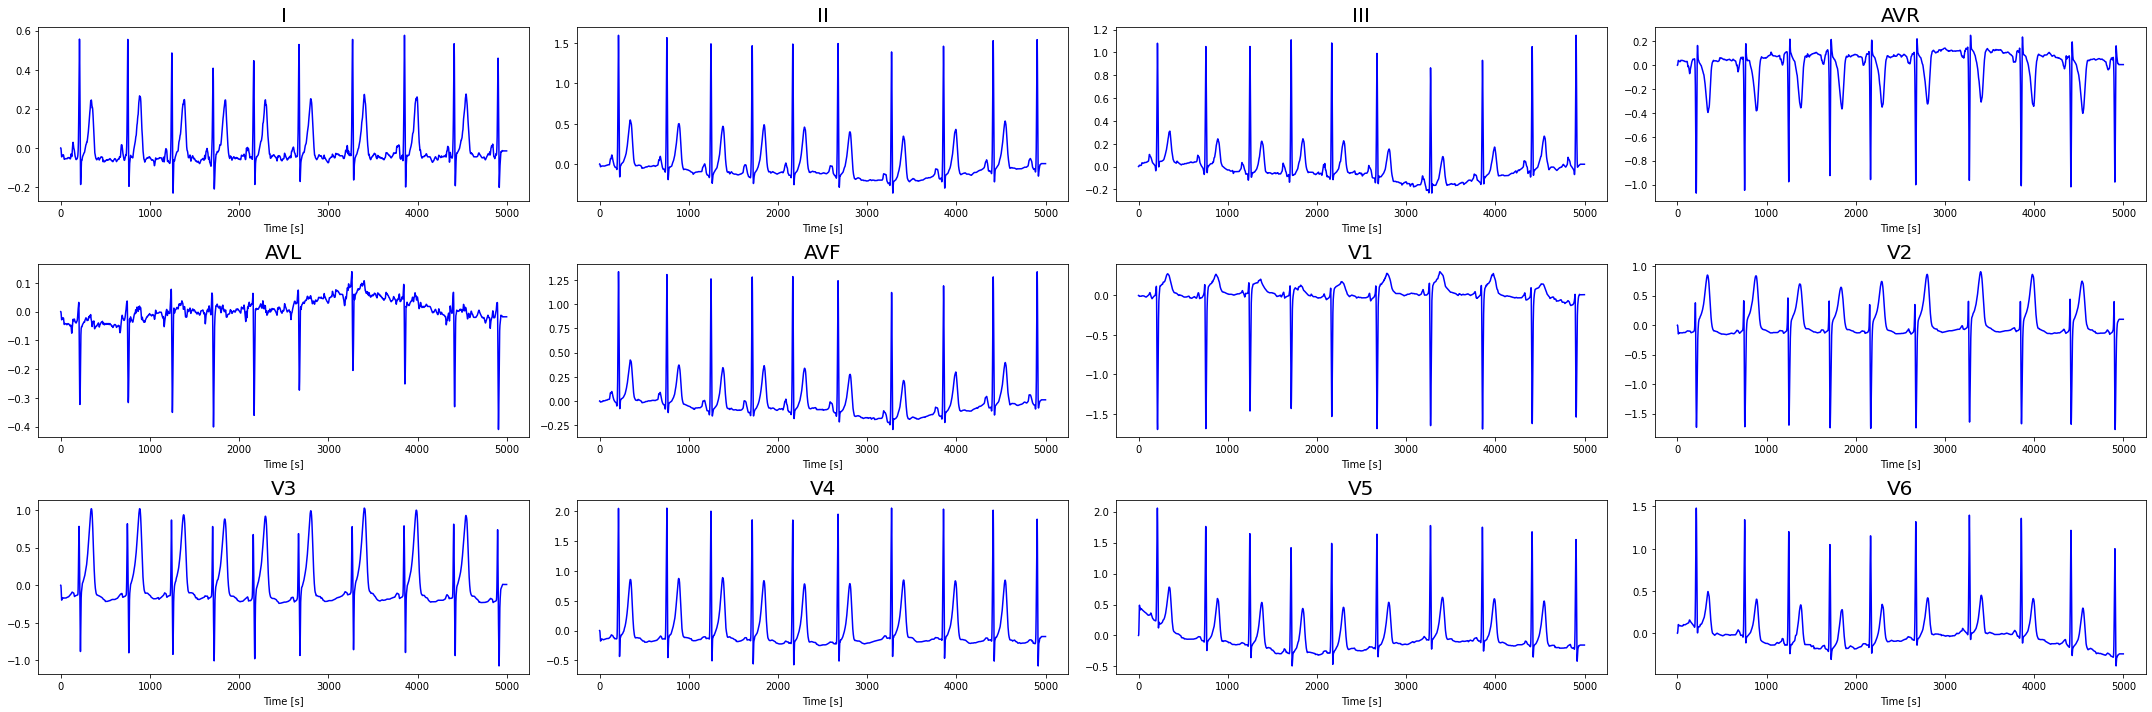

In [12]:
%matplotlib inline
    
fig = plt.figure(figsize=(30,10))
leadNames = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
print(['NORM', 'MI', 'STTC', 'HYP', 'CD'])
s = 9
fs = 500
print(y_test[s])
for i,lead in enumerate(leadNames):
    x = x_test[s][i][0:5000]
    ax1 = fig.add_subplot(3,4,i+1)
    ax1.set_xlabel('Time [s]')
    ax1.plot(x,"b-")
    ax1.set_title(leadNames[i], fontsize=20)
#     ax1.plot(x_test[2][i][0:5000])
fig.tight_layout()

In [13]:
def get_DataLoader(x, y, batch, num_workers, shuffle=False):
    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y)
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=shuffle)
    return dataloader

batch_size = 32
num_workers = 2

train_loader = get_DataLoader(x_train, y_train, batch=32, num_workers=num_workers, shuffle=True)
val_loader = get_DataLoader(x_valid, y_valid, batch=16, num_workers=num_workers, shuffle=True)
test_loader = get_DataLoader(x_test, y_test, batch=16, num_workers=num_workers, shuffle=True)

In [14]:
# Evaluate
from sklearn.metrics import multilabel_confusion_matrix, classification_report

label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']

def Evaluate(model, test_loader):
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    logits_list = []
    gt_list = []
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
#             logits = logits.round()
            logits = logits > 0.5
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
#                 print(gt.astype(int))
                gt_list.append(gt.astype(int))
            
#             print("=======logits=======")
#             print(logits)
#             print("=======GT=======")
#             print(y.cpu().detach().numpy())
#             if step == 0:
#                 np.append()
#             np.concatenate((output_list, logits), axis=0)

    print(classification_report(gt_list, logits_list, target_names=label_names))

In [ ]:
seed = 0
deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
 
writer = SummaryWriter("runs/vit")

#batch64
lr = 1e-4
epochs = 100
model = ViT()
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
early_stopping = EarlyStopping(patience=3, verbose=False)
model.to(device)

loss_list=[]
val_loss_list = []

best_loss = np.inf
best_models = []

for ep in range(epochs):
    train_bar = tqdm(train_loader)
    for step, (x,y) in enumerate(train_bar):
#         print("step :",step, x.shape, "/", y.shape)
        x, y = x.to(device), y.to(device)
        
        model.train()
        logits = model(x)
        loss = criterion(logits, y)
        loss_list.append(loss.mean().item())
        
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()
        train_bar.desc = "Train Epoch[{}/{}] loss: {:.3f}".format(ep+1, epochs, loss.mean().item())
        writer.add_scalar(f"Training loss_Batch_8_lr_5e5", loss.mean(), ep * len(train_loader) + step)
        
#     loss_train = 0
#     with torch.no_grad():
#         model.eval()
#         loss_train = 0
#         for step, (x,y) in enumerate(train_bar):
#             x,y = x.to(device), y.to(device)

#             logits = model(x)
#             lt = criterion(logits, y)
#             loss_train += lt.mean().item()
    
#     print(f"Train_Loss : {loss_train/len(train_loader)}")
    
        
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        val_bar = tqdm(val_loader)
        for v_step, (val_x, val_y) in enumerate(val_bar):
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_logits = model(val_x)
            loss_v = criterion(val_logits, val_y)
            val_loss_list.append(loss_v.mean().item())
            val_loss += loss_v.mean().item()
            writer.add_scalar(f"Validation loss_Batch_8_lr_1e5", loss_v.mean(), ep * len(val_loader) + step)
        print("Validation loss :",val_loss/len(val_loader))

        if best_loss > val_loss:
            print("Validation Loss Decrease.. Best Model, Best Loss update")
            print("Validation loss :",val_loss/len(val_loader))
            best_loss = val_loss
            torch.save(model.state_dict(), f"models/Best_Saved_ViT_model_1120_{round((val_loss/len(val_loader))*100,2)}.pth")
        
#     early_stopping(loss.mean(), model)
#     if early_stopping.early_stop:
#         break
#         if (i+1) % 5 == 0:
#             logtis = logtis > 0.5
#             acc = (logits == y).float().mean()
#             print(f"EPOCH : {ep} : Loss : {loss.mean().item():.5f}, Acc : {acc.item():.5f}")
    
print("Evaluate")
Evaluate(model,test_loader)

  0%|                                                                          | 0/437 [00:00<?, ?it/s]

Validation loss : 0.5663418820187381
Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.5663418820187381


  0%|                                                                          | 0/437 [00:00<?, ?it/s]

Validation loss : 0.5445826491808783
Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.5445826491808783


  0%|                                                                          | 0/437 [00:00<?, ?it/s]

Validation loss : 0.5481851675194692


  0%|                                                                          | 0/437 [00:00<?, ?it/s]

Validation loss : 0.5276774538162092
Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.5276774538162092


  0%|                                                                          | 0/437 [00:00<?, ?it/s]

Validation loss : 0.5100196062429855
Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.5100196062429855


Train Epoch[6/100] loss: 0.553:  32%|██████████▎                     | 141/437 [00:09<00:20, 14.62it/s]

In [ ]:
model = ViT().to(device)
# model.load_state_dict(torch.load("Best_Saved_ViT_model_f192.pth"))
model.load_state_dict(torch.load("models/Best_Saved_ViT_model_1120_30.91.pth"))

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score
label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']
def extract_metrix(idx ,lr, batch ,model, test_loader):
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    logits_list = []
    gt_list = []
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
    #             logits = logits.round()
            logits = logits > 0.5
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
    #                 print(gt.astype(int))
                gt_list.append(gt.astype(int))
    print(f"==================== lr : {lr} | Batch : {batch} | Model IDX : {idx} ====================")
    print(f"Exact Match Ratio, MR : : {accuracy_score(gt_list, logits_list)}")
    print(f"Hamming Loss : {hamming_loss(gt_list, logits_list)}")
    print(classification_report(gt_list, logits_list, target_names=label_names))
    MR = np.all(np.array(logits_list) == np.array(gt_list), axis=1).mean()

In [ ]:
extract_metrix(0, 1e-5, 16, model, test_loader)